<a href="https://colab.research.google.com/github/vaibhavlokunde/AI-ML/blob/main/GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch,pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

`tensor.detach()` → Removes the tensor from computation graph (no gradients needed).

`.cpu()` → Moves the tensor to CPU (in case it's on GPU).

`.view(-1, ch, *size)` → Reshapes the tensor:

`-1` → Automatically infers the batch size.

`ch, *size` → Ensures correct shape ((batch_size, channels, height, width)).

In [2]:
def show(tensor,ch=1,size=(28,28),num=16):
  data=tensor.detach().cpu().view(-1,ch,*size)
  grid=make_grid(data[:num],nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.axis('off')
  plt.show()

In [3]:
epochs=50
cur_step=0
info_step=300
mean_gen_loss=0
mean_disc_loss=0

z_dim=64
lr=0.001
loss_fn=nn.BCEWithLogitsLoss()
bs=128
device="cuda"

In [4]:
data=DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),batch_size=bs,shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


In [5]:
def genBlock(inp,out):
  return nn.Sequential(
    nn.Linear(inp,out),
    nn.BatchNorm1d(out),
    nn.ReLU(inplace=True)
  )

##Understanding Basic GANs (Generative Adversarial Networks)
GANs consist of two neural networks:

Generator (G) – Generates fake images from random noise.

Discriminator (D) – Classifies images as real or fake.

These two networks compete:

Generator tries to fool the discriminator by generating realistic images.

Discriminator tries to correctly classify real vs. fake images.



##Understanding the Generator Class
This class creates the generator that takes a random noise vector (z_dim) as input and transforms it into an image (i_dim = 784 for MNIST, meaning a 28x28 grayscale image).

###Layer-by-Layer Breakdown
1. genBlock(z_dim, hidden_dim)
The first block takes the random noise (z_dim=64) and expands it to hidden_dim=128.

Each genBlock helps gradually upscale the noise into a structured image.

2. Stacked genBlock Layers
Each block doubles the hidden units:

128 → 256 → 512 → 1024 neurons.

This allows the network to learn complex patterns.

3. nn.Linear(hidden_dim*8, i_dim)
Fully connected layer maps the final hidden layer (1024 neurons) to the image size (i_dim=784 for MNIST).

4. nn.Sigmoid()
Applies Sigmoid activation to scale outputs between 0 and 1 (valid pixel range for grayscale images).

In [6]:
class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,hidden_dim=128):
    super(Generator,self).__init__()
    self.gen=nn.Sequential(
      genBlock(z_dim,hidden_dim),
      genBlock(hidden_dim,hidden_dim*2),
      genBlock(hidden_dim*2,hidden_dim*4),
      genBlock(hidden_dim*4,hidden_dim*8),
      nn.Linear(hidden_dim*8,i_dim),
      nn.Sigmoid()
    )
  def forward(self,noise):
    return self.gen(noise)

In [7]:
def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

##Layer-by-Layer Breakdown
1. discBlock(i_dim, hidden_dim * 4)
First discBlock reduces input size from 784 → 1024 neurons.

This extracts important features while reducing dimensionality.

2. Stacked discBlock Layers
Each block halves the number of neurons, reducing complexity:

1024 → 512 → 256 neurons.

This allows the model to focus on the most important patterns.

3. nn.Linear(hidden_dim, 1)
Final fully connected layer (256 → 1 neuron).

Outputs a single scalar value (logit) indicating how real the image is.



In [8]:
class Discriminator(nn.Module):
  def __init__(self,i_dim=784,hidden_dim=256):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
      discBlock(i_dim,hidden_dim*4),
      discBlock(hidden_dim*4,hidden_dim*2),
      discBlock(hidden_dim*2,hidden_dim),
      nn.Linear(hidden_dim,1)
    )
  def forward(self,image):
    return self.disc(image)

In [9]:
def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)

In [10]:
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr)
disc=Discriminator().to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=lr)

In [11]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [12]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([3, 5, 3, 8, 2, 9, 4, 2, 6, 8])


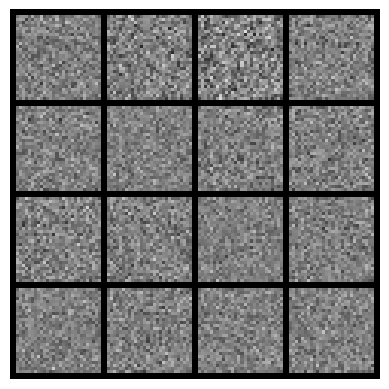

In [13]:
X,y=next(iter(data))
print(X.shape,y.shape)
print(y[:10])

noise=gen_noise(bs,z_dim)
fake=gen(noise)
show(fake)

pred is the Discriminator's output (logits) for fake images.

torch.ones_like(pred) creates a tensor of ones, having the same shape as pred.

This means we are telling the Generator:

"Your goal is to fool the Discriminator into thinking all fake images are real (label=1)."

In [14]:
def calc_gen_loss(loss_fn, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)  # Generate random noise
    fake = gen(noise)  # Generate fake images using Generator
    pred = disc(fake)  # Discriminator's predictions on fake images
    targets = torch.ones_like(pred)  # Create target labels (all ones)
    gen_loss = loss_fn(pred, targets)  # Compute Generator loss
    return gen_loss


In [15]:
def calc_disc_loss(loss_fn,gen,disc,real,number,z_dim):
  noise=gen_noise(number,z_dim)
  fake=gen(noise)
  disc_fake_pred=disc(fake.detach())
  disc_fake_targets=torch.zeros_like(disc_fake_pred)
  disc_fake_loss=loss_fn(disc_fake_pred,disc_fake_targets)

  disc_real_pred=disc(real)
  disc_real_targets=torch.ones_like(disc_real_pred)
  disc_real_loss=loss_fn(disc_real_pred,disc_real_targets)

  disc_loss=(disc_fake_loss+disc_real_loss)/2
  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

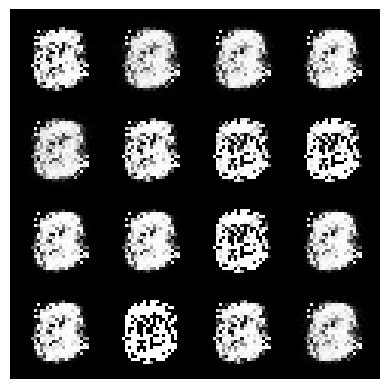

Epoch 0, Step 300: Gen Loss: 11.7977, Disc Loss: 0.1342


  0%|          | 0/469 [00:00<?, ?it/s]

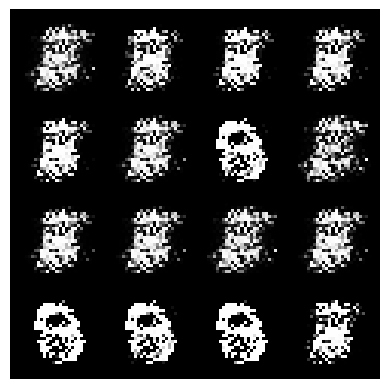

Epoch 1, Step 600: Gen Loss: 11.4182, Disc Loss: 0.0257


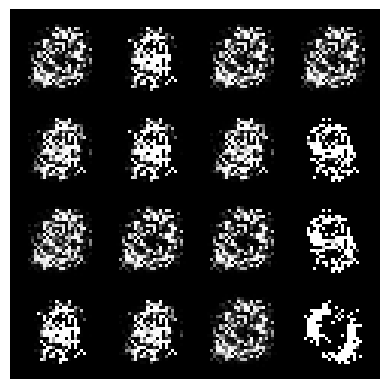

Epoch 1, Step 900: Gen Loss: 15.1680, Disc Loss: 0.0219


  0%|          | 0/469 [00:00<?, ?it/s]

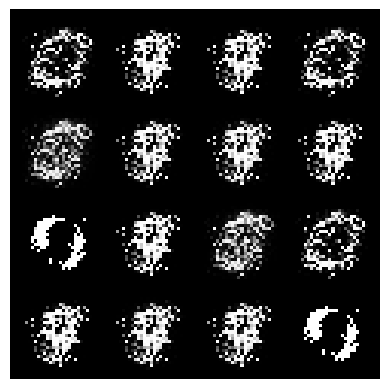

Epoch 2, Step 1200: Gen Loss: 12.2538, Disc Loss: 0.0154


  0%|          | 0/469 [00:00<?, ?it/s]

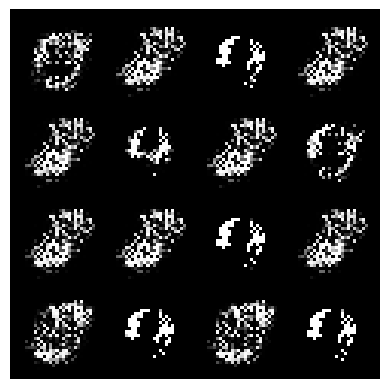

Epoch 3, Step 1500: Gen Loss: 12.9445, Disc Loss: 0.0136


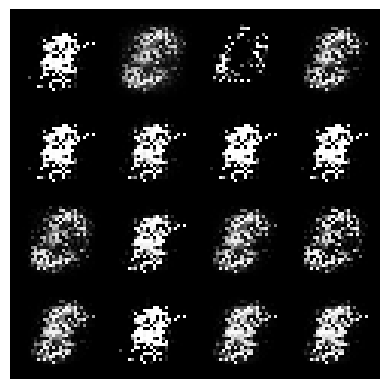

Epoch 3, Step 1800: Gen Loss: 17.7779, Disc Loss: 0.0200


  0%|          | 0/469 [00:00<?, ?it/s]

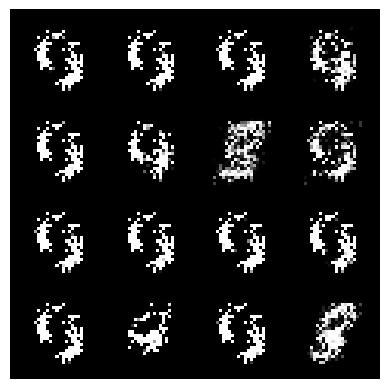

Epoch 4, Step 2100: Gen Loss: 15.3899, Disc Loss: 0.0198


  0%|          | 0/469 [00:00<?, ?it/s]

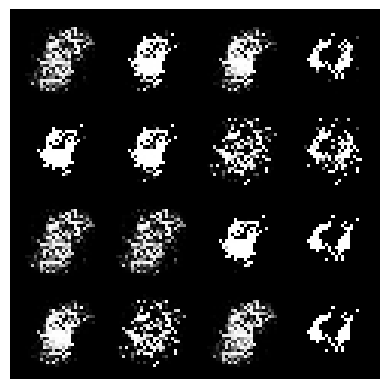

Epoch 5, Step 2400: Gen Loss: 14.9181, Disc Loss: 0.0219


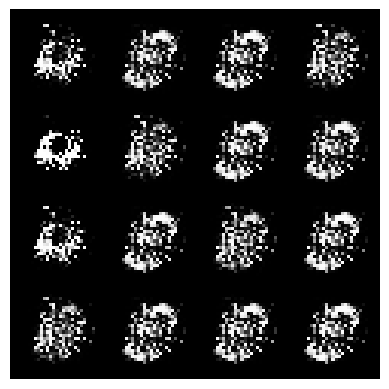

Epoch 5, Step 2700: Gen Loss: 11.8877, Disc Loss: 0.0153


  0%|          | 0/469 [00:00<?, ?it/s]

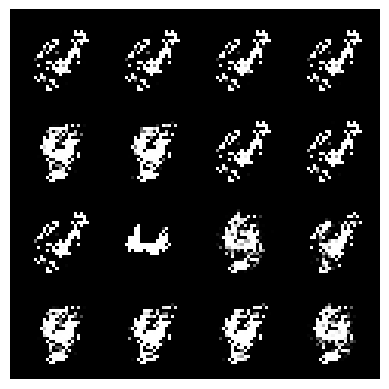

Epoch 6, Step 3000: Gen Loss: 13.9357, Disc Loss: 0.0078


  0%|          | 0/469 [00:00<?, ?it/s]

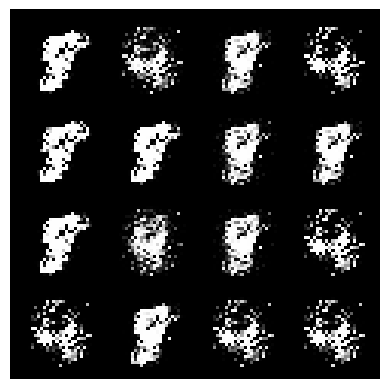

Epoch 7, Step 3300: Gen Loss: 16.2372, Disc Loss: 0.0236


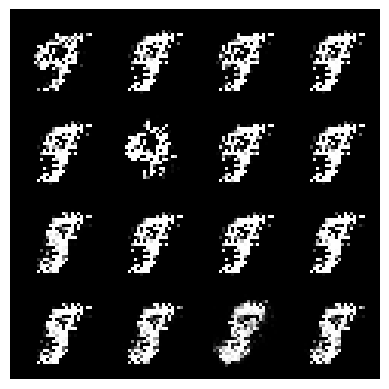

Epoch 7, Step 3600: Gen Loss: 13.5356, Disc Loss: 0.0379


  0%|          | 0/469 [00:00<?, ?it/s]

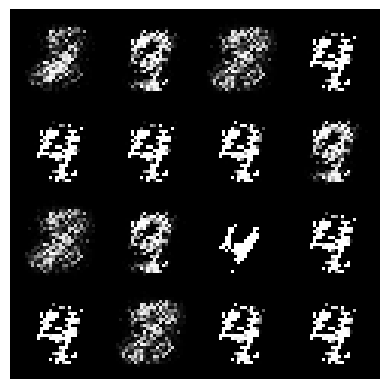

Epoch 8, Step 3900: Gen Loss: 16.4246, Disc Loss: 0.0255


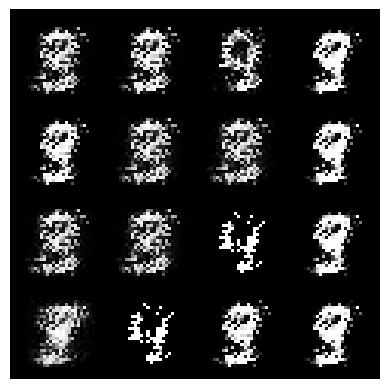

Epoch 8, Step 4200: Gen Loss: 12.0649, Disc Loss: 0.0290


  0%|          | 0/469 [00:00<?, ?it/s]

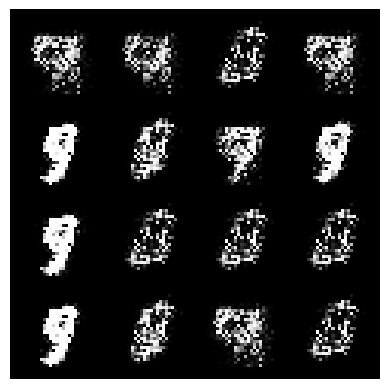

Epoch 9, Step 4500: Gen Loss: 10.0131, Disc Loss: 0.0453


  0%|          | 0/469 [00:00<?, ?it/s]

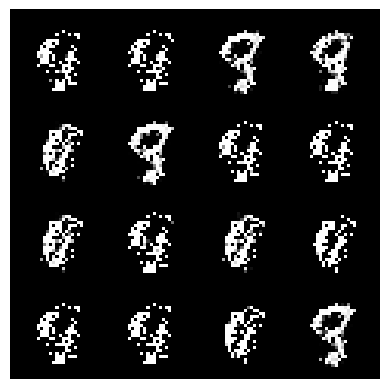

Epoch 10, Step 4800: Gen Loss: 15.0231, Disc Loss: 0.0223


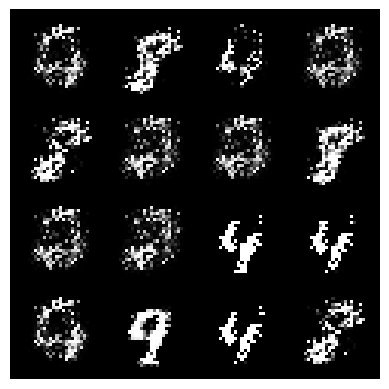

Epoch 10, Step 5100: Gen Loss: 13.2112, Disc Loss: 0.0269


  0%|          | 0/469 [00:00<?, ?it/s]

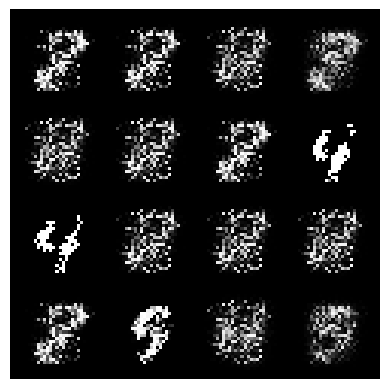

Epoch 11, Step 5400: Gen Loss: 10.4667, Disc Loss: 0.0331


  0%|          | 0/469 [00:00<?, ?it/s]

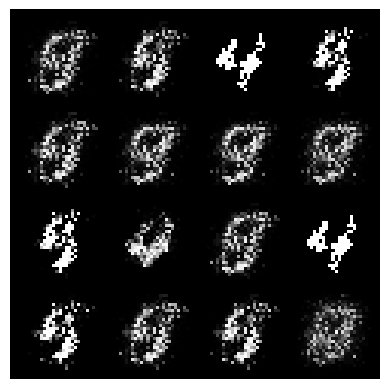

Epoch 12, Step 5700: Gen Loss: 11.6398, Disc Loss: 0.0432


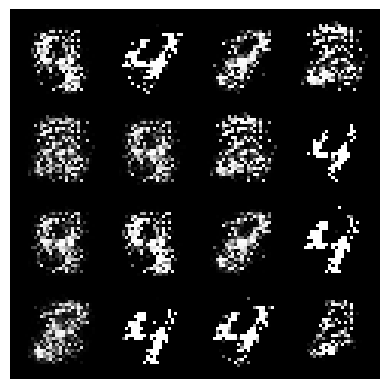

Epoch 12, Step 6000: Gen Loss: 13.0728, Disc Loss: 0.0642


  0%|          | 0/469 [00:00<?, ?it/s]

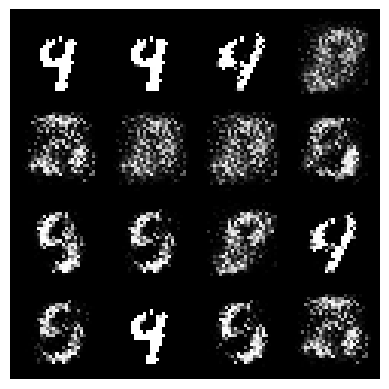

Epoch 13, Step 6300: Gen Loss: 12.3618, Disc Loss: 0.0484


  0%|          | 0/469 [00:00<?, ?it/s]

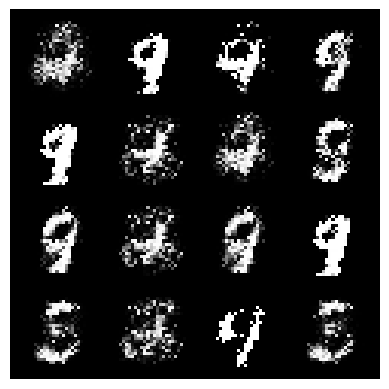

Epoch 14, Step 6600: Gen Loss: 9.1948, Disc Loss: 0.0545


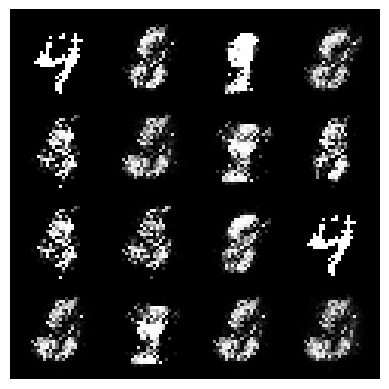

Epoch 14, Step 6900: Gen Loss: 8.4950, Disc Loss: 0.0504


  0%|          | 0/469 [00:00<?, ?it/s]

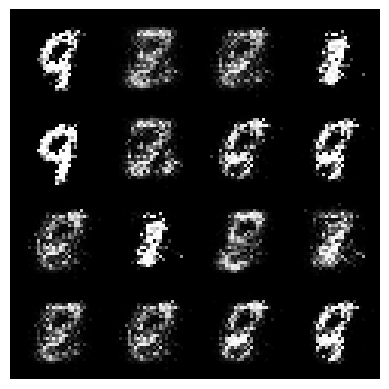

Epoch 15, Step 7200: Gen Loss: 8.4568, Disc Loss: 0.0372


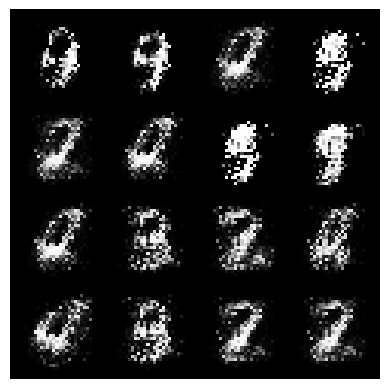

Epoch 15, Step 7500: Gen Loss: 8.9858, Disc Loss: 0.0415


  0%|          | 0/469 [00:00<?, ?it/s]

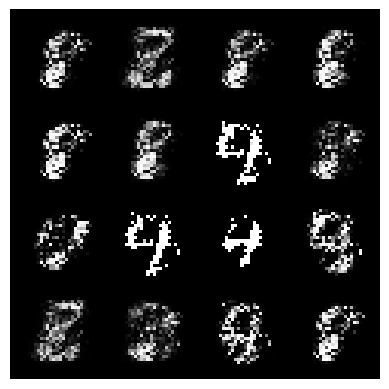

Epoch 16, Step 7800: Gen Loss: 9.0741, Disc Loss: 0.0507


  0%|          | 0/469 [00:00<?, ?it/s]

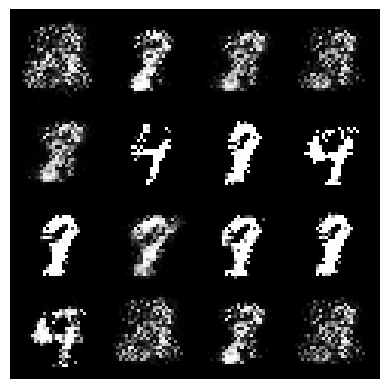

Epoch 17, Step 8100: Gen Loss: 8.0898, Disc Loss: 0.0485


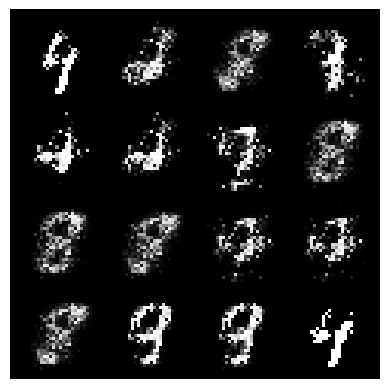

Epoch 17, Step 8400: Gen Loss: 7.1439, Disc Loss: 0.0573


  0%|          | 0/469 [00:00<?, ?it/s]

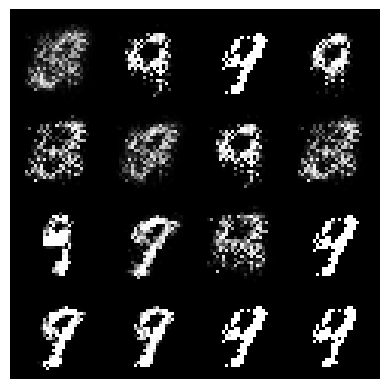

Epoch 18, Step 8700: Gen Loss: 7.8830, Disc Loss: 0.0546


  0%|          | 0/469 [00:00<?, ?it/s]

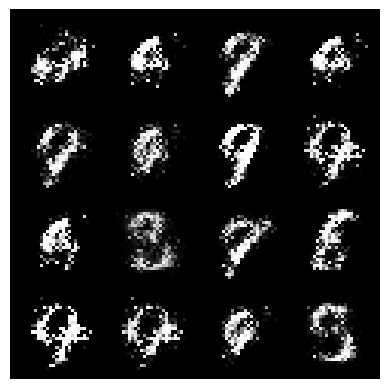

Epoch 19, Step 9000: Gen Loss: 8.7950, Disc Loss: 0.0474


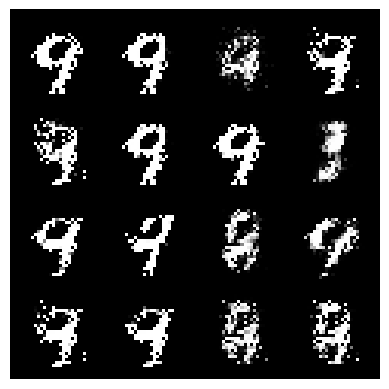

Epoch 19, Step 9300: Gen Loss: 8.2732, Disc Loss: 0.0556


  0%|          | 0/469 [00:00<?, ?it/s]

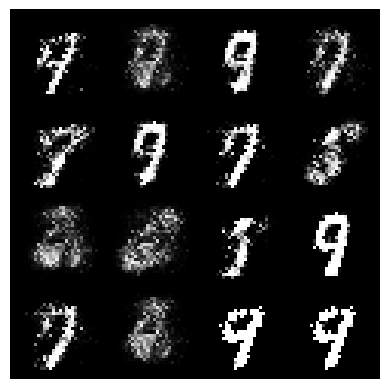

Epoch 20, Step 9600: Gen Loss: 7.4913, Disc Loss: 0.0482


  0%|          | 0/469 [00:00<?, ?it/s]

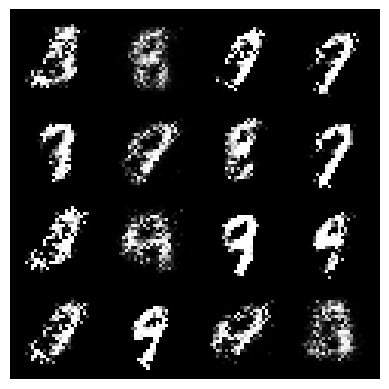

Epoch 21, Step 9900: Gen Loss: 8.2441, Disc Loss: 0.0642


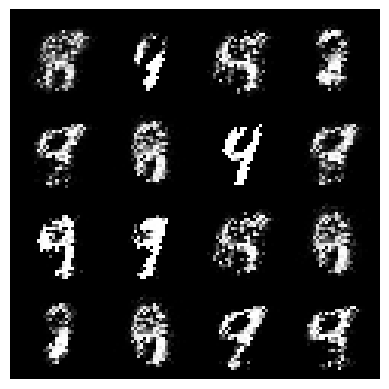

Epoch 21, Step 10200: Gen Loss: 7.1255, Disc Loss: 0.0622


  0%|          | 0/469 [00:00<?, ?it/s]

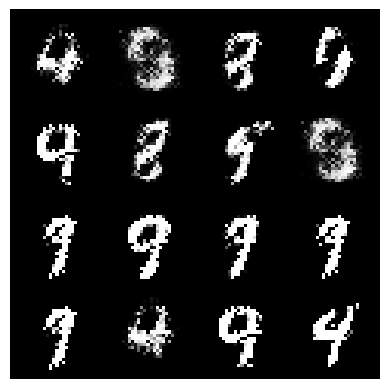

Epoch 22, Step 10500: Gen Loss: 8.0225, Disc Loss: 0.0594


  0%|          | 0/469 [00:00<?, ?it/s]

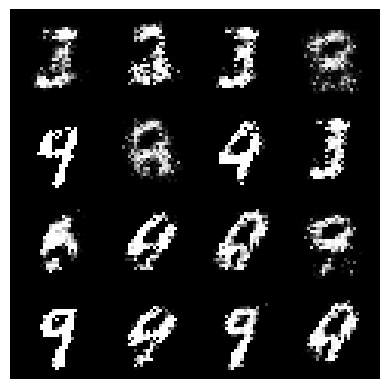

Epoch 23, Step 10800: Gen Loss: 7.3785, Disc Loss: 0.0663


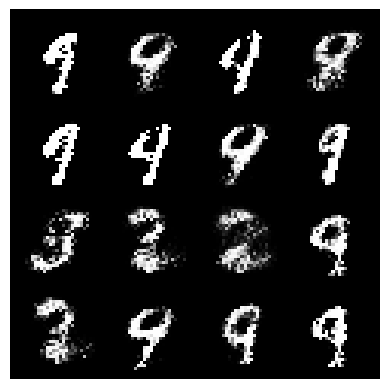

Epoch 23, Step 11100: Gen Loss: 6.6386, Disc Loss: 0.0629


  0%|          | 0/469 [00:00<?, ?it/s]

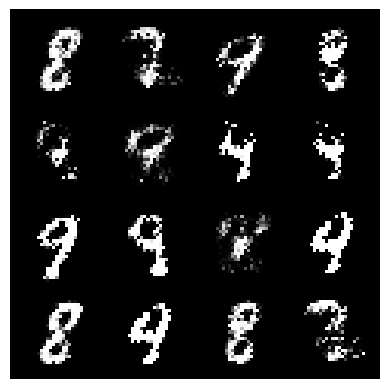

Epoch 24, Step 11400: Gen Loss: 7.2512, Disc Loss: 0.0649


KeyboardInterrupt: 

In [16]:
for epoch in range(epochs):
    for real, _ in tqdm(data):
        cur_bs = real.size(0)  # Get batch size
        real = real.view(cur_bs, -1).to(device)

        # Train Discriminator
        disc_opt.zero_grad()
        disc_loss = calc_disc_loss(loss_fn, gen, disc, real, bs, z_dim)
        disc_loss.backward()
        disc_opt.step()

        # Train Generator
        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_fn, gen, disc, bs, z_dim)
        gen_loss.backward()
        gen_opt.step()

        # Logging
        mean_disc_loss += disc_loss.item() / info_step
        mean_gen_loss += gen_loss.item() / info_step

        if cur_step % info_step == 0 and cur_step > 0:
            show(gen(gen_noise(cur_bs, z_dim)))  # Display generated images
            print(f"Epoch {epoch}, Step {cur_step}: Gen Loss: {mean_gen_loss:.4f}, Disc Loss: {mean_disc_loss:.4f}")
            mean_gen_loss = mean_disc_loss = 0

        cur_step += 1
